# CNN

### Setup
Import libraries

In [1]:
import torch, torchvision
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import torch.nn as nn
import os
import numpy as np
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
torch.manual_seed(0)

### Preprocessing
Transform each image into a Tensor and standardize RGB channels

In [3]:
class Data(Dataset):
    def __init__(self):
        img_list = []
        class_list = []
        for id, city in enumerate(tqdm(['Paris', 'Toronto', 'LosAngeles'])):
            for i in range(300):
                path = '../../images/' + city + 'Resized/' + str(i) + '.png'
                if os.path.isfile(path):
                    img = Image.open(path)
                    img_list.append(np.array(img, dtype=np.float32).tolist())
                    class_list.append(id)
        
        img_arr = np.array(img_list)
        mean, std = img_arr.mean(axis=(0, 1, 2)), img_arr.std(axis=(0, 1, 2))
        print(mean, std)
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])
        self.x = torch.stack([transform(img).to(torch.float32) for img in img_arr], dim=0)
        print(self.x.shape)
        self.y = torch.tensor(class_list)
        self.len = len(self.x)
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    def __len__(self):
        return self.len

In [4]:
dset = Data()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:29<00:00,  9.69s/it]


[118.62847043 118.21799781 114.24897372] [61.27436298 61.19320455 63.7297023 ]
torch.Size([616, 3, 256, 256])


### Training
Build a CNN with 3 convolutional layers (each with batch normalization and reLU activation) and a FC layer. After splitting 80% of the data, the model is trained for 10 epochs with a mini-batch size of 5. The best-performing model has its parameters saved

In [5]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        
        # input: [batch]x3x256x256 
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=7, padding=3)
        self.bn1 = nn.BatchNorm2d(num_features=16)
        # maxpool
        
        # input: [batch]x16x128x128
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(num_features=32)
        # maxpool
        
        # input: [batch]x32x64x64
        self.cnn3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(num_features=64)
        # maxpool

        # input: [batch]x64x32x32
        self.fc1 = nn.Linear(64*32*32, 3)

        # output: [batch]x3
    def forward(self, x):
        x = self.cnn1(x)
        x = self.bn1(x)
        x = torch.relu(x)
        x = self.maxpool(x)
        
        x = self.cnn2(x)
        x = self.bn2(x)
        x = torch.relu(x)
        x = self.maxpool(x)
        
        x = self.cnn3(x)
        x = self.bn3(x)
        x = torch.relu(x)
        x = self.maxpool(x)

        x = x.reshape(x.size(0), -1)
        x = self.fc1(x)
        return x

In [6]:
cnn = CNN()

In [7]:
train_set, val_set = random_split(dset, [0.8, 0.2])
criterion = nn.CrossEntropyLoss()
train_loader = DataLoader(train_set, batch_size=5, shuffle=True)
val_loader = DataLoader(val_set, batch_size=1)
optimizer = torch.optim.SGD(cnn.parameters(), lr=0.001, momentum=0.9)

In [8]:
loss_list = []
acc_list = []
best_acc = 0
file = os.path.join(os.getcwd(), 'cnn.pt')
for epoch in tqdm(range(10)):
    loss_sublist = []
    cnn.train()
    for X, y in train_loader:
        z = cnn(X)
        loss = criterion(z, y)
        loss_sublist.append(loss.data.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_list.append(np.mean(loss_sublist))

    correct = 0
    cnn.eval()
    for X, y in val_loader:
        z = cnn(X)
        _, yhat = torch.max(z.data, 1)
        correct += (yhat == y).sum().item()
    accuracy = correct / len(val_set)
    acc_list.append(accuracy)
    if accuracy > best_acc:
        torch.save(cnn.state_dict(), file)
        best_acc = accuracy
    
    print('epoch '+str(epoch)+' loss: '+str(np.mean(loss_sublist)))
    print('epoch '+str(epoch)+' accuracy: '+str(accuracy))

 10%|██████████▉                                                                                                  | 1/10 [00:26<03:59, 26.56s/it]

epoch 0 loss: 11.098757217393604
epoch 0 accuracy: 0.5528455284552846


 20%|█████████████████████▊                                                                                       | 2/10 [00:51<03:23, 25.46s/it]

epoch 1 loss: 2.0185724782101597
epoch 1 accuracy: 0.6016260162601627


 30%|████████████████████████████████▋                                                                            | 3/10 [01:14<02:50, 24.34s/it]

epoch 2 loss: 0.6792291860622965
epoch 2 accuracy: 0.6910569105691057


 40%|███████████████████████████████████████████▌                                                                 | 4/10 [01:38<02:25, 24.20s/it]

epoch 3 loss: 0.4492815351584042
epoch 3 accuracy: 0.6991869918699187


 50%|██████████████████████████████████████████████████████▌                                                      | 5/10 [02:01<01:58, 23.77s/it]

epoch 4 loss: 0.35694129681661535
epoch 4 accuracy: 0.7073170731707317


 60%|█████████████████████████████████████████████████████████████████▍                                           | 6/10 [02:24<01:33, 23.47s/it]

epoch 5 loss: 0.3183853333496084
epoch 5 accuracy: 0.7073170731707317


 70%|████████████████████████████████████████████████████████████████████████████▎                                | 7/10 [02:46<01:09, 23.24s/it]

epoch 6 loss: 0.19682150556132047
epoch 6 accuracy: 0.6747967479674797


 80%|███████████████████████████████████████████████████████████████████████████████████████▏                     | 8/10 [03:09<00:46, 23.15s/it]

epoch 7 loss: 0.2551960242992135
epoch 7 accuracy: 0.6910569105691057


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████           | 9/10 [03:32<00:23, 23.00s/it]

epoch 8 loss: 0.1452749793869302
epoch 8 accuracy: 0.6991869918699187


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:55<00:00, 23.59s/it]

epoch 9 loss: 0.14083652048738618
epoch 9 accuracy: 0.6585365853658537


### Evaluation
Load in the best-performing model. First show the confusion matrix on the testing data (20% of total data)

C:\Users\joshu\AppData\Local\Temp\ipykernel_32736\3527458315.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn.load_state_dict(torch.load(file))


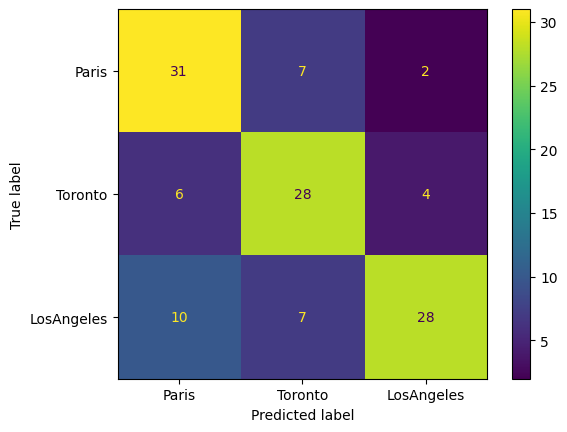

In [9]:
cnn = CNN()
cnn.load_state_dict(torch.load(file))
y_test = []
y_pred = []
cnn.eval()
for X, y in val_loader:
    z = cnn(X)
    _, yhat = torch.max(z.data, 1)
    y_pred.append(yhat.item())
    y_test.append(y.item())
conf_matrix = confusion_matrix(y_test, y_pred)
conf_disp = ConfusionMatrixDisplay(conf_matrix, display_labels=['Paris', 'Toronto', 'LosAngeles'])
conf_disp.plot()
plt.show()

Let's take a look at how the model performed after each epoch

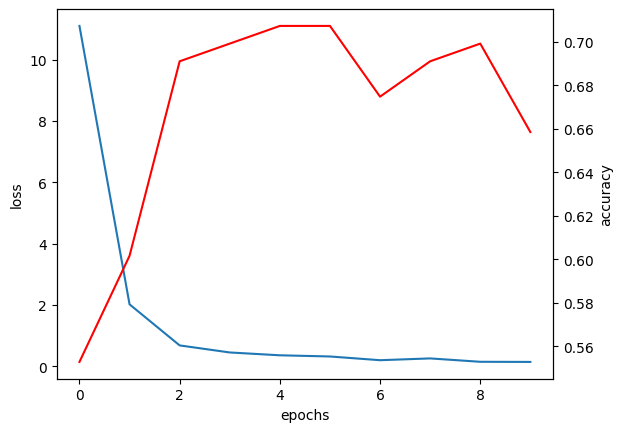

In [10]:
fig, ax1 = plt.subplots()

ax1.plot(list(range(10)), loss_list)
ax1.set_ylabel('loss')
ax1.set_xlabel('epochs')

ax2 = ax1.twinx()
ax2.plot(list(range(10)), acc_list, color='red')
ax2.set_ylabel('accuracy')

plt.show()

We can also visualize the weights of every convolutional layer (16x3x7x7, 32x16x3x3, 64x32x3x3). Although semi-random, sometimes this can show patterns we are looking for

In [11]:
def plot_weights(W):
    m = W.shape[0]
    n = W.shape[1]
    w_min, w_max = W.min().item(), W.max().item()
    fig, axes = plt.subplots(m, n, figsize=(5, 8))
    fig.subplots_adjust(hspace=0.1)
    m_cntr = n_cntr = 0
    for ax in axes.flat:
        if n_cntr > n-1:
            m_cntr += 1
            n_cntr = 0
        ax.imshow(W[m_cntr, n_cntr, :, :], vmin = w_min, vmax = w_max, cmap='seismic')
        ax.axis('off')
        n_cntr += 1
    plt.show()

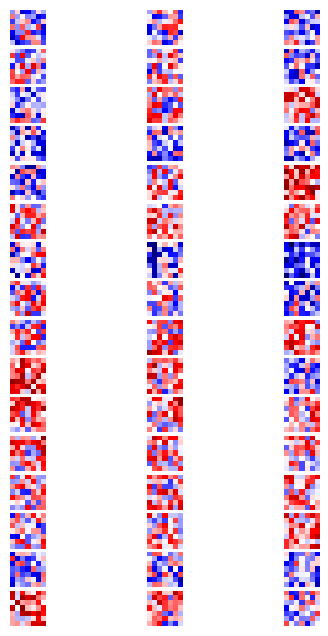

In [12]:
plot_weights(cnn.state_dict()['cnn1.weight'])

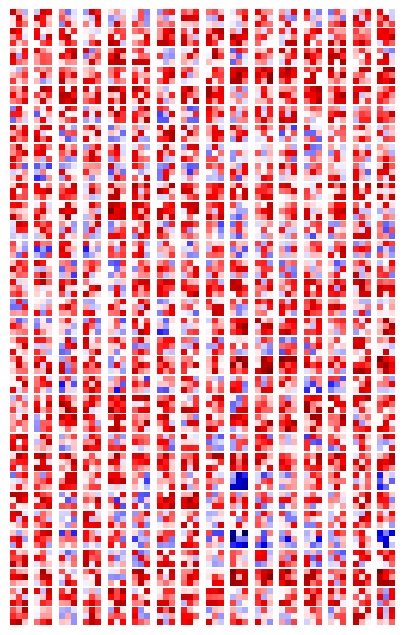

In [13]:
plot_weights(cnn.state_dict()['cnn2.weight'])

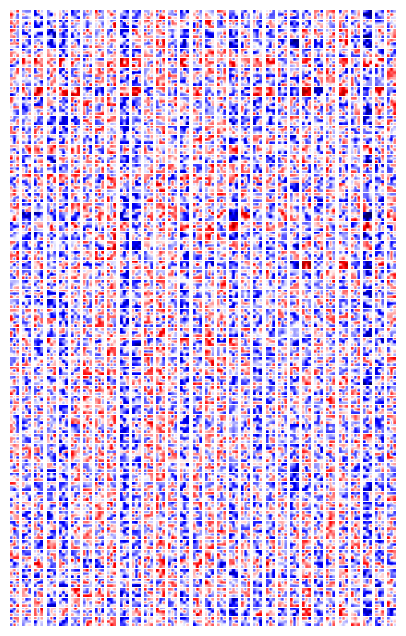

In [14]:
plot_weights(cnn.state_dict()['cnn3.weight'])